# Symmetry Reduced VQE

The first step is to find the blocks of a Hamiltonian which has have been reduced due to the application of some symmerty consideration.  Each block will then have an associated wavefunction,
$$ |\psi^b> = U(\phi^b_1,\phi^b_1,\ldots)|000\ldots> $$
where $|000\ldots>$ is the state in which $Q$ qubits are in their ground state with $Q$ deterimed by the size of the block $N$ as $Q = \log_2 N$ rounded up and $U$ is a linear transformation with some set of parameters $\{\phi^b_i\}$ which depend on the block.  

For this notebook we will use the linear transformation Anzatz from here: https://arxiv.org/abs/1907.01493.  It gives $U$ as applying y-rotations to each qubit, then coupling each qubit pair with a C-not gate and repreating. 
$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$
where the $\pm$ in the subscripts of the C-not gates alternates (see below for an exact definition).

The Hamiltonian might be block diagonal or it might have some nonzero off diagonal blocks.  In the most general case, the minimization function invovles wave functions from different blocks.  

$$ E = \sum_{a,b}<\psi^a|H_{ab}|\psi^b> $$

To minimize this function we will use the simultaneous perturbation stochastic approximation algorithm.

## Hamiltonian

As an example for this notebook we will use the Hamiltonian generated from Example_Matrix_Creation_Sign_Fix.ipynb

I do not know how to export the summed operator from OpFlow so I will import the numpy matrix and then re-extract the Pauli terms here.

In [2]:
import numpy as np 

H = np.load('Hamiltonian_Example.npy')

In [3]:
e,y = np.linalg.eig(H)

np.sort(e)

array([-3.34084762e+00+0.00000000e+00j, -3.29295138e+00+0.00000000e+00j,
       -2.86387634e+00+0.00000000e+00j, -2.78526086e+00+0.00000000e+00j,
       -1.56155281e+00+0.00000000e+00j, -1.56155281e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -5.61552813e-01+0.00000000e+00j, -5.61552813e-01+0.00000000e+00j,
        7.31507328e-16+0.00000000e+00j,  5.07690516e-01+0.00000000e+00j,
        5.23028722e-01+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00-1.27192026e-16j,
        1.00000000e+00+1.27192026e-16j,  1.47697128e+00+0.00000000e+00j,
        1.49230948e+00+0.00000000e+00j,  2.00000000e+00+0.00000000e+00j,
        2.56155281e+00+0.00000000e+00j,  2.56155281e+00+0.00000000e+00j,
        3.00000000e+00+0.00000000e+00j,  3.00000000

Now that the Hamiltonian has been imported let us break it into blocks and exctract the Pauli coordinates.  

In [4]:
from qiskit.opflow import (I, X, Y, Z)
from qiskit.opflow.primitive_ops import MatrixOp

# Function to add elements to a block so that it fits onto qubits
def complete_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        vnew[i] = 10
        b11.append(vnew)
    return b11

def complete_off_diagonal(b11):
    size = 2**np.ceil(np.log2(len(b11)))
    for v in b11:
        while len(v) < size:
            v.append(0.0)
    while len(b11) < size:
        i = len(b11)
        vnew = [0.0 for i in range(0,8)]
        b11.append(vnew)
    return b11



In [5]:
import math
N = 4
S = 2
bL = math.comb(4,2)

blocks = {}
for bi in range(bL):
    for bj in range(bi,bL):
        bij = [[H[i + bL*bi][j + bL*bj] for j in range(0,bL)] for i in range(0,bL)]
        if np.amax(np.abs(bij)) > 10**(-5):
            if bi == bj:
                bij = complete_diagonal(bij)
            else:
                bij = complete_off_diagonal(bij)
            bij_pauli = MatrixOp(bij).to_pauli_op()
            blocks[str(bi) + ',' + str(bj)] = bij_pauli
        

The object *blocks* is a dictionary of *SumedOp* lists of *PauliOp* objects.  

In [6]:
import pandas as pd

pd.DataFrame(blocks['3,4'].to_matrix())

,0,1,2,3,4,5,6,7
0,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
1,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
2,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
3,0.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
4,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
5,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,-1.0+0.0j,0.0+0.0j,0.0+0.0j
6,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
7,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j


In [7]:
print(blocks['0,0'])

SummedOp([
  3.25 * III,
  -0.5 * IIX,
  0.25 * IIZ,
  -0.25 * IXI,
  -0.25 * IXX,
  0.25 * IXZ,
  -0.25 * IYY,
  -2.25 * IZI,
  -0.5 * IZX,
  0.25 * IZZ,
  0.5 * XII,
  -0.25 * XXI,
  -0.25 * XXX,
  -0.25 * XXZ,
  0.25 * XYY,
  0.5 * XZI,
  -0.25 * YXY,
  -0.25 * YYI,
  -0.25 * YYX,
  -0.25 * YYZ,
  -2.0 * ZII,
  -0.25 * ZXI,
  -0.25 * ZXX,
  0.25 * ZXZ,
  -0.25 * ZYY,
  2.5 * ZZI
])


Let's take a sanity check here and make sure we can rebuild a Hamiltonian with these completed blocks and that the ground state is still the same.

In [8]:
keys = list(blocks.keys())

size = int(2**np.ceil(np.log2(bL)))
H_complete = np.array([[0 for i in range(size**2)] for j in range(size**2)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            block = blocks[key].to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]

<ipython-input-8-ce06f5abc6d5>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-8-ce06f5abc6d5>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [9]:
e_comp,y_comp = np.linalg.eig(H_complete)

print(np.sort(e_comp)[0])
print(np.sort(e)[0])

-3.3408476172483366
(-3.340847617248337+0j)


## The Anzatz circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [10]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute


# the number of qubits is given by the size of the blocks
# note: the size of the blocks has already been adjusted to fit the qubits
Q = int(np.log2(len(blocks['0,0'].to_matrix())))


In [11]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

def Ui_dagger(cir_i,phi_i):  
    
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(0,Q):
        cir_i.ry(-phi_i[q],q)
    
    return cir_i

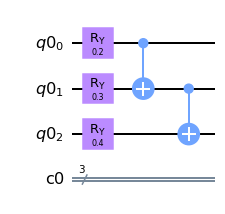

In [12]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

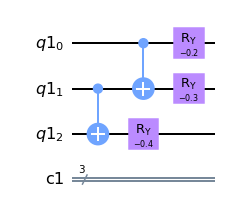

In [13]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)

tst_dagger = Ui_dagger(cir_i,[0.2,0.3,0.4])
tst_dagger.draw(output = 'mpl')

In [14]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir

def U_dagger(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui_dagger(cir,phi_b[T-1-t])
    return cir

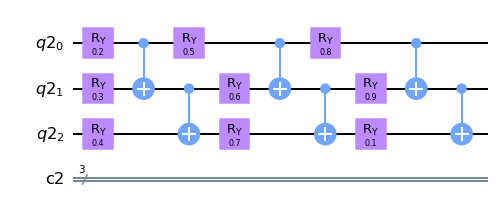

In [15]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

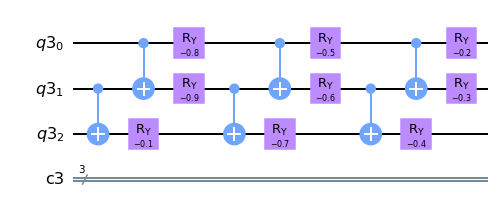

In [16]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U_dagger(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

First we need to inialize our set of parameters.  To do this we need to decide on the number of times we will apply Ui.  As a first attempt let's just have a depth of 1 (i.e. $U = Ui$).  

In this case, we need a parameter for each qubit for each section.

In [17]:
#number of blocks
T = 2

phi = []
for b in range(bL):
    phi_b = []
    for t in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)

The structure of $\phi_{b,t,q}$ is by section in the first index, by number of application of $U_i$ in the second index, and by qubit in the third index

Instead of using circuits to find $E$ I will convert $U$ into a statevector and each block into a matrix.  This should run faster so that we can explore the parameters in SPSA.

In [18]:
import copy

In [19]:
from qiskit import quantum_info as qi

def bkt(psi2,h,psi1):
    return np.dot(np.conjugate(psi2),np.dot(h,psi1))



def E_From_Matrix(phi,blocks):
    E = 0
    for key in list(blocks.keys()):
        qr = QuantumRegister(Q)
        cr = ClassicalRegister(Q)
        cir0 = QuantumCircuit(qr , cr)
        a = int(key.split(',')[0])
        b = int(key.split(',')[1])
        w = 1
        if a != b:
            w = 2
        cir = copy.deepcopy(cir0)
        psi_1 = qi.Statevector.from_instruction(U(cir,phi[b])).data
        h = blocks[key].to_matrix()
        cir = copy.deepcopy(cir0)
        psi_2 = qi.Statevector.from_instruction(U(cir,phi[a])).data
        E_key = bkt(psi_2,h,psi_1)
        E += w*E_key
    return E/bL
            

In [20]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
qi.Statevector.from_instruction(U(cir,phi[0])).data

E_From_Matrix(phi,blocks)

(-0.3333333333333333+0j)

For a sanity check, let's compare this to simple matrix multiplication

In [21]:
all_down = [0 for i in range(len(H))]
for b in range(bL):
    all_down[bL*b + 1] = 1/np.sqrt(bL)
    
np.dot(all_down,np.dot(H,all_down))

-0.3333333333333334

# Optimization

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [26]:
def SPSA(k_max,hold = False):
    #Initalization
    k = 0
    #alpha = 0.602
    alpha = 0.201
    A = 10
    a = 0.4
    gamma = 0.101
    c = 0.4
    phi_k = np.array(phi)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**alpha)
        c_k = c/((k + 1)**gamma)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
            
        #Find E    
        E_A = E_From_Matrix(phi_k + c_k*Delta_k ,blocks)
        E_B = E_From_Matrix(phi_k - c_k*Delta_k ,blocks)
        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k

        
        #Calculate new E
        E_f = np.real(E_From_Matrix(phi_k,blocks))
        
        #Print and save E
        print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [27]:
out = SPSA(500,hold=True)

k= 0 c_k= 0.4 a_k= 0.24702451859678626 g= -0.10329282230457343 E_A= (0.46439028971806384+0j) E_B= (0.5470245475617226+0j) E_f= -0.320870733764678
k= 1 c_k= 0.372954594574733 a_k= 0.24274179599678827 g= 0.8932749210959717 E_A= (0.7531238867218759+0j) E_B= (0.08682191463962642+0j) E_f= -0.28959018415117277
k= 2 c_k= 0.3579898757427053 a_k= 0.23886767231070002 g= -0.10495287636943877 E_A= (0.4071733200579576+0j) E_B= (0.4823174543986274+0j) E_f= -0.28949095580558704
k= 3 c_k= 0.34773782403600867 a_k= 0.23533593967153557 g= -0.6790940933750187 E_A= (0.11974599183015422+0j) E_B= (0.5920393965220244+0j) E_f= -0.23526977792398865
k= 4 c_k= 0.33998833831625347 a_k= 0.23209492713998128 g= -0.8647476680198487 E_A= (-0.017742702518269517+0j) E_B= (0.5702655429075777+0j) E_f= -0.22517191054988475
k= 5 c_k= 0.3337849224236992 a_k= 0.2291035795959514 g= 2.01059256850685 E_A= (1.0779688176827131+0j) E_B= (-0.2642421513267369+0j) E_f= -0.04384638033110744
k= 6 c_k= 0.32862839767254015 a_k= 0.226328767

k= 52 c_k= 0.267860162826851 a_k= 0.17393722653866475 g= 0.08917298225864688 E_A= (0.33512268309699644+0j) E_B= (0.28735090400188235+0j) E_f= -0.008254837907243646
k= 53 c_k= 0.26735494522142605 a_k= 0.1733875127029373 g= 2.0538805624071985 E_A= (0.7674780523510629+0j) E_B= (-0.33075219815639356+0j) E_f= -0.302701130864267
k= 54 c_k= 0.2668599250350944 a_k= 0.1728480190624269 g= -0.07902712106786121 E_A= (-0.13952066755612536+0j) E_B= (-0.09734232434830781+0j) E_f= -0.30403129932276096
k= 55 c_k= 0.26637471655715955 a_k= 0.17231840269622573 g= -0.44742583985641426 E_A= (-0.18318253133983475+0j) E_B= (0.055183331204368094+0j) E_f= -0.3275781856698002
k= 56 c_k= 0.2658989552298248 a_k= 0.17179833716619697 g= 1.7348239008896413 E_A= (0.5455847695201139+0j) E_B= (-0.37699095598845567+0j) E_f= -0.33156391329072354
k= 57 c_k= 0.26543229614067565 a_k= 0.17128751149258062 g= 1.9736521981800768 E_A= (0.5666565600815363+0j) E_B= (-0.48108550941052297+0j) E_f= -0.39540996901280645
k= 58 c_k= 0.26

k= 103 c_k= 0.25023014297472496 a_k= 0.15439104836212222 g= -0.297233627456263 E_A= (-1.0135351609730021+0j) E_B= (-0.8647815347824485+0j) E_f= -1.2509559891173272
k= 104 c_k= 0.24998840873867942 a_k= 0.1541202573111085 g= -0.19653630780283302 E_A= (-0.9939777823825945+0j) E_B= (-0.8957141846885834+0j) E_f= -1.2498566124758623
k= 105 c_k= 0.24974919607452548 a_k= 0.15385227960119216 g= -0.9166369063135213 E_A= (-0.9064877173021106+0j) E_B= (-0.4486290564140265+0j) E_f= -1.2082999461761865
k= 106 c_k= 0.2495124552599996 a_k= 0.15358706212572473 g= 0.7352620765128646 E_A= (-0.6052310775733907+0j) E_B= (-0.9721451695139717+0j) E_f= -1.196066216900969
k= 107 c_k= 0.24927813800651724 a_k= 0.1533245532236118 g= 0.18842415857622533 E_A= (-0.7878404221982795+0j) E_B= (-0.8817804690089319+0j) E_f= -1.1968413893821872
k= 108 c_k= 0.24904619740500722 a_k= 0.15306470262810792 g= 0.8181704813035556 E_A= (-0.3740017996197319+0j) E_B= (-0.7815262940150821+0j) E_f= -1.1385724023626689
k= 109 c_k= 0.24

k= 154 c_k= 0.24034577371294386 a_k= 0.14333284411377514 g= 1.3992978690766753 E_A= (-0.5558143252290175+0j) E_B= (-1.2284449832252318+0j) E_f= -1.2927972186490158
k= 155 c_k= 0.2401897150315199 a_k= 0.1431588712952899 g= 0.04559881046188474 E_A= (-0.9342026819532501+0j) E_B= (-0.9561074125344828+0j) E_f= -1.29252411406133
k= 156 c_k= 0.24003475389827156 a_k= 0.1429861526294766 g= 0.4433652423545208 E_A= (-0.8148103053153705+0j) E_B= (-1.0276564389866003+0j) E_f= -1.3000511602882048
k= 157 c_k= 0.23988087567680955 a_k= 0.14281467164615091 g= 1.2122405781869927 E_A= (-0.7881428051688799+0j) E_B= (-1.3697294680217953+0j) E_f= -1.4110677078791327
k= 158 c_k= 0.239728066017013 a_k= 0.14264441218782992 g= 0.8456686168962926 E_A= (-0.6859536742221933+0j) E_B= (-1.0914146782618543+0j) E_f= -1.3922397410282914
k= 159 c_k= 0.23957631084767136 a_k= 0.14247535840198608 g= -0.9809690838623306 E_A= (-1.3262059877296104+0j) E_B= (-0.8561720793948961+0j) E_f= -1.4304789435110101
k= 160 c_k= 0.2394255

k= 205 c_k= 0.23353899237344763 a_k= 0.13577968204298357 g= 0.7321098743498563 E_A= (-0.9915711176478796+0j) E_B= (-1.3335235223725133+0j) E_f= -1.572105274229318
k= 206 c_k= 0.23342479519724088 a_k= 0.13565368158301086 g= 0.46413522450152156 E_A= (-1.2333307644572282+0j) E_B= (-1.4500121039034144+0j) E_f= -1.579538188151988
k= 207 c_k= 0.23331120380879006 a_k= 0.13552837655812258 g= 0.2472574817834779 E_A= (-1.137579360162286+0j) E_B= (-1.2529552416135523+0j) E_f= -1.5840289188549024
k= 208 c_k= 0.2331982121051757 a_k= 0.13540375996623283 g= -0.4530746991466771 E_A= (-1.4221040875899336+0j) E_B= (-1.2107916680077426+0j) E_f= -1.5976611943885959
k= 209 c_k= 0.23308581407379206 a_k= 0.1352798249073219 g= 0.394180024831059 E_A= (-1.2920180261212817+0j) E_B= (-1.4757735700800316+0j) E_f= -1.6150803506518694
k= 210 c_k= 0.232974003790588 a_k= 0.1351565645814929 g= -0.679146441420857 E_A= (-1.3848034711643193+0j) E_B= (-1.0683565399284252+0j) E_f= -1.625726247319354
k= 211 c_k= 0.2328627754

k= 256 c_k= 0.22837930441497245 a_k= 0.13011615698394097 g= -0.37397898146781167 E_A= (-1.5643177129257273+0j) E_B= (-1.39349959361885+0j) E_f= -1.7692582349856996
k= 257 c_k= 0.22828974396591784 a_k= 0.13001842406950276 g= 0.2515531463039518 E_A= (-1.4399152331260283+0j) E_B= (-1.5547692398531288+0j) E_f= -1.7707828426458305
k= 258 c_k= 0.22820056489801344 a_k= 0.1299211281515303 g= 0.4901581372710921 E_A= (-1.3493774369670781+0j) E_B= (-1.5730861645963206+0j) E_f= -1.7823178611527006
k= 259 c_k= 0.22811176412405826 a_k= 0.12982426566240393 g= -0.13728337697819756 E_A= (-1.5525341739316394+0j) E_B= (-1.4899022673168298+0j) E_f= -1.7834805113875514
k= 260 c_k= 0.22802333859359442 a_k= 0.12972783307670635 g= 0.031533396937693726 E_A= (-1.452764587419793+0j) E_B= (-1.4671452883136529+0j) E_f= -1.7835391216221583
k= 261 c_k= 0.22793528529233112 a_k= 0.1296318269105699 g= -0.19509253110737734 E_A= (-1.5848192572255837+0j) E_B= (-1.4958823137528576+0j) E_f= -1.7858960171420262
k= 262 c_k= 0

k= 307 c_k= 0.2242416957476633 a_k= 0.1256238618873561 g= -0.6412362334369759 E_A= (-1.8455389894094059+0j) E_B= (-1.557955188687902+0j) E_f= -1.9899006666423358
k= 308 c_k= 0.22416829307647623 a_k= 0.12554460772379422 g= 0.48527924561270924 E_A= (-1.533269982985857+0j) E_B= (-1.7508384232947392+0j) E_f= -1.9969524232149622
k= 309 c_k= 0.22409515148215373 a_k= 0.12546565138325588 g= -0.4756599248973802 E_A= (-1.6471078099520897+0j) E_B= (-1.4339216441043532+0j) E_f= -1.9883723518910874
k= 310 c_k= 0.2240222691984007 a_k= 0.12538699082110985 g= -0.3878472445157734 E_A= (-1.746903824123506+0j) E_B= (-1.573130984485965+0j) E_f= -1.9935613852345384
k= 311 c_k= 0.2239496444765029 a_k= 0.12530862401307563 g= -0.2034632801660615 E_A= (-1.7089160919615902+0j) E_B= (-1.617785033447165+0j) E_f= -1.9959676378409168
k= 312 c_k= 0.22387727558509607 a_k= 0.12523054895495883 g= -0.3738579457306356 E_A= (-1.7062126750715862+0j) E_B= (-1.5388160783795555+0j) E_f= -2.0054193280479864
k= 313 c_k= 0.22380

k= 358 c_k= 0.22079816106773162 a_k= 0.12192357593159786 g= -0.04636566563125685 E_A= (-1.7440990754854246+0j) E_B= (-1.723624168069299+0j) E_f= -2.060125179249044
k= 359 c_k= 0.22073613743405993 a_k= 0.12185727014166509 g= -0.538809706945865 E_A= (-1.7737591451303185+0j) E_B= (-1.5358895980839025+0j) E_f= -2.059765752243025
k= 360 c_k= 0.22067430319994108 a_k= 0.12179117922823361 g= 0.4631647477620806 E_A= (-1.5349554447793372+0j) E_B= (-1.7393725607376844+0j) E_f= -2.0601967046268435
k= 361 c_k= 0.2206126572647566 a_k= 0.12172530191858201 g= 0.003160715710406964 E_A= (-1.794298210694603+0j) E_B= (-1.7956927984780657+0j) E_f= -2.060199052047788
k= 362 c_k= 0.2205511985373019 a_k= 0.12165963695092283 g= 0.15459495017047617 E_A= (-1.7407016770126325+0j) E_B= (-1.8088938801084584+0j) E_f= -2.060609887347144
k= 363 c_k= 0.22048992593568012 a_k= 0.12159418307427958 g= -0.1806243680703701 E_A= (-1.8190235666055534+0j) E_B= (-1.7393718595295236+0j) E_f= -2.0618910533835235
k= 364 c_k= 0.2204

k= 409 c_k= 0.21785564705344662 a_k= 0.11879191512878434 g= 0.28884057765328947 E_A= (-1.8744972484646514+0j) E_B= (-2.0003483503445487+0j) E_f= -2.197705854173801
k= 410 c_k= 0.2178020521092889 a_k= 0.11873514585310181 g= 0.02140260981976619 E_A= (-1.8021299038082619+0j) E_B= (-1.8114529684867409+0j) E_f= -2.197622563722602
k= 411 c_k= 0.21774860054507708 a_k= 0.1186785382943916 g= -0.12907452774683287 E_A= (-1.8837578476375747+0j) E_B= (-1.8275462520717956+0j) E_f= -2.200764582509059
k= 412 c_k= 0.21769529163061768 a_k= 0.11862209161039372 g= 0.4895178517058803 E_A= (-1.7243587496360964+0j) E_B= (-1.9374902126071065+0j) E_f= -2.2089781454391506
k= 413 c_k= 0.21764212464119265 a_k= 0.1185658049652129 g= -0.04272011570429918 E_A= (-1.768246804126722+0j) E_B= (-1.7496514106331196+0j) E_f= -2.208845365896315
k= 414 c_k= 0.217589098857505 a_k= 0.11850967752925558 g= -0.7733197708647079 E_A= (-1.9177807591859506+0j) E_B= (-1.5812488550436625+0j) E_f= -2.1908797694965716
k= 415 c_k= 0.21753

k= 459 c_k= 0.2153383843708989 a_k= 0.1161363899055954 g= -0.06907880496132812 E_A= (-1.94511791949759+0j) E_B= (-1.9153672829883004+0j) E_f= -2.2697653515926595
k= 460 c_k= 0.21529116004852789 a_k= 0.11608678642493254 g= 0.2868593989485405 E_A= (-1.9512903371336048+0j) E_B= (-2.0748069226745143+0j) E_f= -2.276274074500177
k= 461 c_k= 0.2152440483769229 a_k= 0.11603730926690842 g= -0.052942141942132696 E_A= (-1.9386115552545644+0j) E_B= (-1.9158205933318238+0j) E_f= -2.276591127733115
k= 462 c_k= 0.21519704884440038 a_k= 0.11598795784321132 g= 0.19249496882332137 E_A= (-1.8378364277180688+0j) E_B= (-1.920685126134416+0j) E_f= -2.279256366805724
k= 463 c_k= 0.21515016094269962 a_k= 0.11593873156950592 g= -0.13052103426345182 E_A= (-1.9863590890647391+0j) E_B= (-1.9301958460083606+0j) E_f= -2.281017840560758
k= 464 c_k= 0.21510338416695282 a_k= 0.11588962986539796 g= -0.49311841079127894 E_A= (-1.9409525434611026+0j) E_B= (-1.7288096655486351+0j) E_f= -2.2785969681303917
k= 465 c_k= 0.21

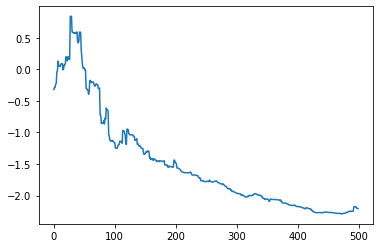

In [29]:
import matplotlib.pyplot as plt

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [135]:
phi_f = out[len(out)-1]['phi']

E_From_Matrix(phi_f,blocks)

(-1.9823161057295846+0j)

In [136]:
np.sort(e)

array([-3.34084762e+00+0.00000000e+00j, -3.29295138e+00+0.00000000e+00j,
       -2.86387634e+00+0.00000000e+00j, -2.78526086e+00+0.00000000e+00j,
       -1.56155281e+00+0.00000000e+00j, -1.56155281e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -1.00000000e+00+0.00000000e+00j, -1.00000000e+00+0.00000000e+00j,
       -5.61552813e-01+0.00000000e+00j, -5.61552813e-01+0.00000000e+00j,
        7.31507328e-16+0.00000000e+00j,  5.07690516e-01+0.00000000e+00j,
        5.23028722e-01+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  1.00000000e+00-1.27192026e-16j,
        1.00000000e+00+1.27192026e-16j,  1.47697128e+00+0.00000000e+00j,
        1.49230948e+00+0.00000000e+00j,  2.00000000e+00+0.00000000e+00j,
        2.56155281e+00+0.00000000e+00j,  2.56155281e+00+0.00000000e+00j,
        3.00000000e+00+0.00000000e+00j,  3.00000000

In [139]:
import pickle

file_to_store = open("VQE_Example.pickle", "wb")

pickle.dump(out, file_to_store)

In [1]:
import pickle

file_to_read = open("VQE_Example.pickle", "rb")

loaded_object = pickle.load(file_to_read)

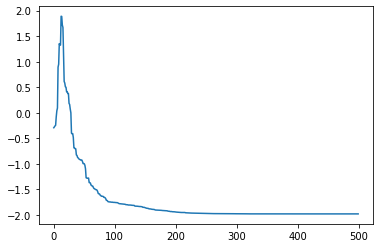

In [2]:
import matplotlib.pyplot as plt

El = [loaded_object[i]['E'] for i in range(len(loaded_object))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)

In [5]:
loaded_object[0]['Delta']

array([[[ 1, -1, -1]],

       [[-1,  1,  1]],

       [[ 1, -1, -1]],

       [[ 1, -1,  1]],

       [[-1, -1,  1]],

       [[ 1, -1,  1]]])